**Visual Saliency of Gemma Models**

This notebook demonstrates how to compute visual saliency for the Gemma models to visualize which parts of the image are most important for the model's predictions. The saliency maps can help understand the model's focus areas and improve interpretability.

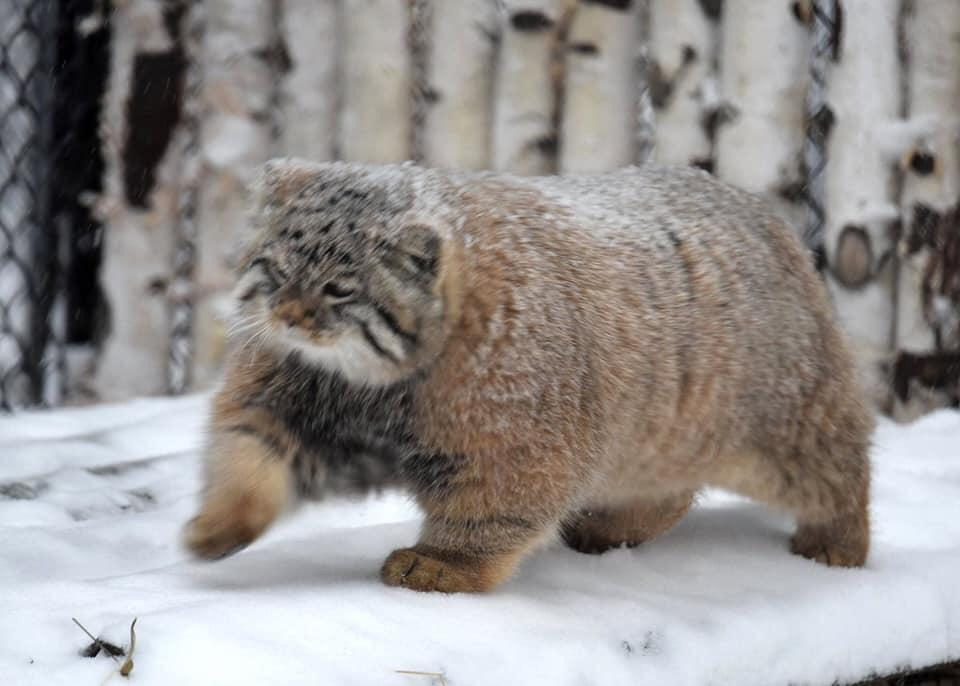

In [4]:
import requests
from PIL import Image

model_name = "google/gemma-3-4b-it"

prompt = "What is shown in this image?"
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"

image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
image

## Initalization

Initialize the model and processor for the Gemma model you want to analyze. 

In [5]:
import torch
import transformers
from transformers import AutoProcessor, Gemma3ForConditionalGeneration

transformers.utils.logging.set_verbosity_error()
torch.set_float32_matmul_precision("high")  # Set float32 matmul precision for better performance with Gemma models

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Gemma3ForConditionalGeneration.from_pretrained(
    model_name,
    dtype=torch.float32,  # Requires float32 for loss computation
    attn_implementation="eager",  # to get attention weights
).to(device)

processor = AutoProcessor.from_pretrained(model_name, padding_side="left")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Process input images and text to prepare them for the model.

In [6]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": image_url},
            {"type": "text", "text": prompt},
        ],
    },
]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    add_generation_prompt=True,
).to(device)

## Extract Saliency

Initalize the saliency extractor with the correct model.


In [7]:
from vl_saliency import SaliencyExtractor

extractor = SaliencyExtractor(model, processor)

Generate the response

In [8]:
with torch.inference_mode():
    generated_ids = model.generate(**inputs, do_sample=True, max_new_tokens=200)

# Compute attention and gradients
trace = extractor.capture(**inputs, generated_ids=generated_ids)  # type: ignore
trace.visualize_tokens()

Compute and visualize the saliency map.

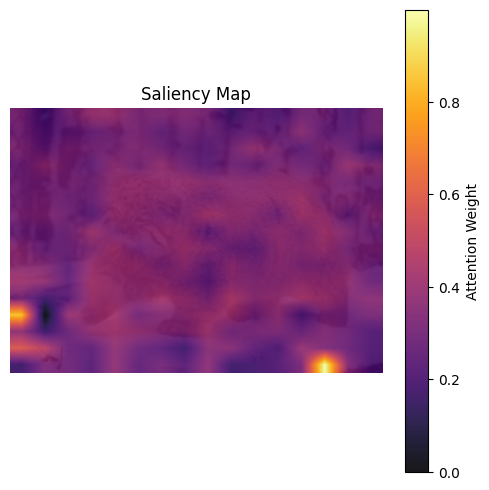

In [14]:
from vl_saliency.lib import agcam

saliency_map = trace.map(token=13, mode=agcam)  # _Cat
fig = saliency_map.agg().plot(image, alpha=0.9)